In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

with open('data_with_ratios.pickle', 'rb') as fp:
    data = pickle.load(fp)
data[0]

{'x53': [{'value': 0.9145980517057226, 'date': '10/11/11'},
  {'value': 1.0928171417995873, 'date': '11/5/12'},
  {'value': 1.1346162810054936, 'date': '8/2/13'},
  {'value': 1.0925080494017012, 'date': '7/2/14'},
  {'value': 0.6958480424113458, 'date': '6/2/15'},
  {'value': 0.769333428659946, 'date': '5/2/16'},
  {'value': 0.8582450700768856, 'date': '10/2/17'},
  {'value': 1.1437394527899964, 'date': '9/2/18'}],
 'x18': [{'value': 0.9791174734356553, 'date': '10/11/11'},
  {'value': 1.1001198859952046, 'date': '11/5/12'},
  {'value': 1.050675971873959, 'date': '8/2/13'},
  {'value': 1.1052013830878387, 'date': '7/2/14'},
  {'value': 0.7526393218558743, 'date': '6/2/15'},
  {'value': 0.8083032445517532, 'date': '5/2/16'},
  {'value': 0.8493489499192246, 'date': '10/2/17'},
  {'value': 0.7621226857881845, 'date': '9/2/18'}],
 'x54': [{'value': 0.3185280984184586, 'date': '10/11/11'},
  {'value': 0.32763950674828124, 'date': '11/5/12'},
  {'value': 0.3313267854170135, 'date': '8/2/13'}

In [3]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

new_data = []
bankrupt = []
cols = data[0].keys()
MIN_ROWS = 5
ZSCORE = 2.2
for obj in data:
    if (len(obj.keys()) <= 18):
        continue
    cols = intersection(cols, obj.keys())
cols = sorted(cols)
for obj in data:
    if (len(obj.keys()) <= 18):
        continue
    valid = True
    new_obj = []
    for i in range(MIN_ROWS):
        new_vals = []
        for key in cols:
            if (isinstance(obj[key], list)):
                if len(obj[key]) < MIN_ROWS:
                    valid = False
                    break
                new_vals.append(obj[key][i]['value'])
        new_obj.append(new_vals)
    if (valid):
        ban = obj['bankrupt']
        if ('zscore' in obj):
            for zscore in obj['zscore']:
                if zscore['value'] < ZSCORE:
                    ban = True
        bankrupt.append(ban)
        new_data.append(new_obj)

In [4]:
arr = np.array(new_data)
arr.shape

(1600, 5, 7)

In [5]:
def train_model(x_train, y_train, units, dropout, num_lstm_layers, model_type, epoch, batch_size):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'lstm' 
            else GRU(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'gru' 
            else SimpleRNN(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True) if model_type == 'lstm' else 
            GRU(units, return_sequences=True) if model_type == 'gru' else
            SimpleRNN(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units) if model_type == 'lstm' else 
            GRU(units) if model_type == 'gru' else
            SimpleRNN(units),
            Dropout(dropout),
            Dense(1, activation = 'sigmoid')
        ])
    model.compile(optimizer=optimizers.RMSprop(lr=0.003),loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size)
    return model, history

In [6]:
scalers = {}
for i in range(arr.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(0,1))
    arr[:, :, i] = scalers[i].fit_transform(arr[:, :, i])
x_train, x_test, y_train, y_test = train_test_split(arr, bankrupt, test_size=0.15, random_state=42)
print('bankrupt:')
print(len([True for b in bankrupt if b]))
print('not bankrupt:')
print(len([True for b in bankrupt if not b]))

bankrupt:
742
not bankrupt:
858


In [7]:
EPOCH = 2000
BATCH_SIZE = 30
LSTM_UNITS = 100
DROPOUT = 0.2
NUM_LSTM_LAYERS = 5
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm', EPOCH, BATCH_SIZE)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
1360/1360 [==============================] - 3s 3ms/step - loss: 0.6945 - acc: 0.5199
Epoch 2/2000
1360/1360 [==============================] - 1s 617us/step - loss: 0.6923 - acc: 0.5176
Epoch 3/2000
1360/1360 [==============================] - 1s 615us/step - loss: 0.6938 - acc: 0.5250
Epoch 4/2000
1360/1360 [==============================] - 1s 922us/step - loss: 0.6929 - acc: 0.5235
Epoch 5/2000
1360/1360 [==============================] - 1s 961us/step - loss: 0.6925 - acc: 0.5221
Epoch 6/2000
1360/1360 [==============================] - 1s 931us/step - loss: 0.6929 - acc: 0.5199
Epoch 7/2000
1360/1360 [==============================] - 1s 977us/step - loss: 0.6931 - acc: 0.5250
Epoch 8/2000
1360/1360 [==============================] - 1s

1360/1360 [==============================] - 1s 643us/step - loss: 0.6491 - acc: 0.6000
Epoch 73/2000
1360/1360 [==============================] - 1s 609us/step - loss: 0.6436 - acc: 0.6176
Epoch 74/2000
1360/1360 [==============================] - 1s 627us/step - loss: 0.6438 - acc: 0.6206
Epoch 75/2000
1360/1360 [==============================] - 1s 593us/step - loss: 0.6504 - acc: 0.5993
Epoch 76/2000
1360/1360 [==============================] - 1s 592us/step - loss: 0.6446 - acc: 0.6140
Epoch 77/2000
1360/1360 [==============================] - 1s 587us/step - loss: 0.6515 - acc: 0.5949
Epoch 78/2000
1360/1360 [==============================] - 1s 587us/step - loss: 0.6450 - acc: 0.6184
Epoch 79/2000
1360/1360 [==============================] - 1s 593us/step - loss: 0.6522 - acc: 0.6206
Epoch 80/2000
1360/1360 [==============================] - 1s 595us/step - loss: 0.6452 - acc: 0.6287
Epoch 81/2000
1360/1360 [==============================] - 1s 595us/step - loss: 0.6414 - acc: 0

Epoch 152/2000
1360/1360 [==============================] - 1s 611us/step - loss: 0.6180 - acc: 0.6368
Epoch 153/2000
1360/1360 [==============================] - 1s 652us/step - loss: 0.6234 - acc: 0.6426
Epoch 154/2000
1360/1360 [==============================] - 1s 605us/step - loss: 0.6202 - acc: 0.6353
Epoch 155/2000
1360/1360 [==============================] - 1s 607us/step - loss: 0.6268 - acc: 0.6426
Epoch 156/2000
1360/1360 [==============================] - 1s 657us/step - loss: 0.6215 - acc: 0.6360
Epoch 157/2000
1360/1360 [==============================] - 1s 614us/step - loss: 0.6238 - acc: 0.6419
Epoch 158/2000
1360/1360 [==============================] - 1s 598us/step - loss: 0.6174 - acc: 0.6463
Epoch 159/2000
1360/1360 [==============================] - 1s 613us/step - loss: 0.6164 - acc: 0.6434
Epoch 160/2000
1360/1360 [==============================] - 1s 654us/step - loss: 0.6162 - acc: 0.6441
Epoch 161/2000
1360/1360 [==============================] - 1s 597us/step

1360/1360 [==============================] - 1s 610us/step - loss: 0.6062 - acc: 0.6574
Epoch 232/2000
1360/1360 [==============================] - 1s 576us/step - loss: 0.6045 - acc: 0.6463
Epoch 233/2000
1360/1360 [==============================] - 1s 573us/step - loss: 0.6160 - acc: 0.6419
Epoch 234/2000
1360/1360 [==============================] - 1s 643us/step - loss: 0.6079 - acc: 0.6632
Epoch 235/2000
1360/1360 [==============================] - 1s 577us/step - loss: 0.6118 - acc: 0.6397
Epoch 236/2000
1360/1360 [==============================] - 1s 578us/step - loss: 0.6100 - acc: 0.6515
Epoch 237/2000
1360/1360 [==============================] - 1s 607us/step - loss: 0.6155 - acc: 0.6493
Epoch 238/2000
1360/1360 [==============================] - 1s 630us/step - loss: 0.6137 - acc: 0.6478
Epoch 239/2000
1360/1360 [==============================] - 1s 575us/step - loss: 0.6073 - acc: 0.6515
Epoch 240/2000
1360/1360 [==============================] - 1s 574us/step - loss: 0.6029

1360/1360 [==============================] - 1s 592us/step - loss: 0.5919 - acc: 0.6647
Epoch 311/2000
1360/1360 [==============================] - 1s 590us/step - loss: 0.5963 - acc: 0.6529
Epoch 312/2000
1360/1360 [==============================] - 1s 589us/step - loss: 0.6057 - acc: 0.6478
Epoch 313/2000
1360/1360 [==============================] - 1s 643us/step - loss: 0.5985 - acc: 0.6588
Epoch 314/2000
1360/1360 [==============================] - 1s 576us/step - loss: 0.5960 - acc: 0.6500
Epoch 315/2000
1360/1360 [==============================] - 1s 573us/step - loss: 0.6031 - acc: 0.6493
Epoch 316/2000
1360/1360 [==============================] - 1s 603us/step - loss: 0.5946 - acc: 0.6574
Epoch 317/2000
1360/1360 [==============================] - 1s 631us/step - loss: 0.5892 - acc: 0.6537
Epoch 318/2000
1360/1360 [==============================] - 1s 586us/step - loss: 0.5982 - acc: 0.6640
Epoch 319/2000
1360/1360 [==============================] - 1s 590us/step - loss: 0.5938

1360/1360 [==============================] - 1s 655us/step - loss: 0.5780 - acc: 0.6574
Epoch 390/2000
1360/1360 [==============================] - 1s 578us/step - loss: 0.5885 - acc: 0.6691
Epoch 391/2000
1360/1360 [==============================] - 1s 576us/step - loss: 0.5846 - acc: 0.6728
Epoch 392/2000
1360/1360 [==============================] - 1s 600us/step - loss: 0.5832 - acc: 0.6610
Epoch 393/2000
1360/1360 [==============================] - 1s 622us/step - loss: 0.5856 - acc: 0.6618
Epoch 394/2000
1360/1360 [==============================] - 1s 594us/step - loss: 0.5816 - acc: 0.6654
Epoch 395/2000
1360/1360 [==============================] - 1s 588us/step - loss: 0.5887 - acc: 0.6603
Epoch 396/2000
1360/1360 [==============================] - 1s 624us/step - loss: 0.5886 - acc: 0.6618
Epoch 397/2000
1360/1360 [==============================] - 1s 614us/step - loss: 0.5836 - acc: 0.6529
Epoch 398/2000
1360/1360 [==============================] - 1s 583us/step - loss: 0.5865

1360/1360 [==============================] - 1s 571us/step - loss: 0.5724 - acc: 0.6684
Epoch 469/2000
1360/1360 [==============================] - 1s 634us/step - loss: 0.5830 - acc: 0.6757
Epoch 470/2000
1360/1360 [==============================] - 1s 574us/step - loss: 0.5739 - acc: 0.6735
Epoch 471/2000
1360/1360 [==============================] - 1s 584us/step - loss: 0.5781 - acc: 0.6728
Epoch 472/2000
1360/1360 [==============================] - 1s 598us/step - loss: 0.5799 - acc: 0.6721
Epoch 473/2000
1360/1360 [==============================] - 1s 623us/step - loss: 0.5684 - acc: 0.6772
Epoch 474/2000
1360/1360 [==============================] - 1s 575us/step - loss: 0.5860 - acc: 0.6669
Epoch 475/2000
1360/1360 [==============================] - 1s 575us/step - loss: 0.5771 - acc: 0.6603
Epoch 476/2000
1360/1360 [==============================] - 1s 608us/step - loss: 0.5822 - acc: 0.6640
Epoch 477/2000
1360/1360 [==============================] - 1s 614us/step - loss: 0.5727

1360/1360 [==============================] - 1s 594us/step - loss: 0.5657 - acc: 0.6662
Epoch 548/2000
1360/1360 [==============================] - 1s 559us/step - loss: 0.5495 - acc: 0.6956
Epoch 549/2000
1360/1360 [==============================] - 1s 567us/step - loss: 0.5557 - acc: 0.6890
Epoch 550/2000
1360/1360 [==============================] - 1s 593us/step - loss: 0.5565 - acc: 0.6772
Epoch 551/2000
1360/1360 [==============================] - 1s 590us/step - loss: 0.5786 - acc: 0.6757
Epoch 552/2000
1360/1360 [==============================] - 1s 547us/step - loss: 0.5601 - acc: 0.6794
Epoch 553/2000
1360/1360 [==============================] - 1s 554us/step - loss: 0.5615 - acc: 0.6882
Epoch 554/2000
1360/1360 [==============================] - 1s 594us/step - loss: 0.5651 - acc: 0.6846
Epoch 555/2000
1360/1360 [==============================] - 1s 578us/step - loss: 0.5590 - acc: 0.6824
Epoch 556/2000
1360/1360 [==============================] - 1s 552us/step - loss: 0.5606

1360/1360 [==============================] - 1s 605us/step - loss: 0.5609 - acc: 0.6772
Epoch 627/2000
1360/1360 [==============================] - 1s 575us/step - loss: 0.5319 - acc: 0.7044
Epoch 628/2000
1360/1360 [==============================] - 1s 548us/step - loss: 0.5411 - acc: 0.6956
Epoch 629/2000
1360/1360 [==============================] - 1s 558us/step - loss: 0.5423 - acc: 0.6949
Epoch 630/2000
1360/1360 [==============================] - 1s 601us/step - loss: 0.5542 - acc: 0.6853
Epoch 631/2000
1360/1360 [==============================] - 1s 563us/step - loss: 0.5477 - acc: 0.6934
Epoch 632/2000
1360/1360 [==============================] - 1s 557us/step - loss: 0.5515 - acc: 0.6941
Epoch 633/2000
1360/1360 [==============================] - 1s 564us/step - loss: 0.5549 - acc: 0.6787
Epoch 634/2000
1360/1360 [==============================] - 1s 607us/step - loss: 0.5395 - acc: 0.6904
Epoch 635/2000
1360/1360 [==============================] - 1s 557us/step - loss: 0.5484

1360/1360 [==============================] - 1s 574us/step - loss: 0.5422 - acc: 0.6956
Epoch 706/2000
1360/1360 [==============================] - 1s 598us/step - loss: 0.5317 - acc: 0.7015
Epoch 707/2000
1360/1360 [==============================] - 1s 549us/step - loss: 0.5411 - acc: 0.7000
Epoch 708/2000
1360/1360 [==============================] - 1s 545us/step - loss: 0.5239 - acc: 0.7074
Epoch 709/2000
1360/1360 [==============================] - 1s 576us/step - loss: 0.5478 - acc: 0.6934
Epoch 710/2000
1360/1360 [==============================] - 1s 596us/step - loss: 0.5271 - acc: 0.6993
Epoch 711/2000
1360/1360 [==============================] - 1s 555us/step - loss: 0.5389 - acc: 0.7081
Epoch 712/2000
1360/1360 [==============================] - 1s 562us/step - loss: 0.5455 - acc: 0.6904
Epoch 713/2000
1360/1360 [==============================] - 1s 589us/step - loss: 0.5309 - acc: 0.7000
Epoch 714/2000
1360/1360 [==============================] - 1s 583us/step - loss: 0.5585

1360/1360 [==============================] - 1s 551us/step - loss: 0.5264 - acc: 0.7015
Epoch 785/2000
1360/1360 [==============================] - 1s 597us/step - loss: 0.5377 - acc: 0.6971
Epoch 786/2000
1360/1360 [==============================] - 1s 569us/step - loss: 0.5195 - acc: 0.7059
Epoch 787/2000
1360/1360 [==============================] - 1s 553us/step - loss: 0.5574 - acc: 0.6897
Epoch 788/2000
1360/1360 [==============================] - 1s 559us/step - loss: 0.5234 - acc: 0.7066
Epoch 789/2000
1360/1360 [==============================] - 1s 607us/step - loss: 0.5391 - acc: 0.6978
Epoch 790/2000
1360/1360 [==============================] - 1s 569us/step - loss: 0.5238 - acc: 0.7022
Epoch 791/2000
1360/1360 [==============================] - 1s 563us/step - loss: 0.5234 - acc: 0.7029
Epoch 792/2000
1360/1360 [==============================] - 1s 560us/step - loss: 0.5294 - acc: 0.6949
Epoch 793/2000
1360/1360 [==============================] - 1s 610us/step - loss: 0.5241

1360/1360 [==============================] - 1s 560us/step - loss: 0.5115 - acc: 0.7132
Epoch 864/2000
1360/1360 [==============================] - 1s 566us/step - loss: 0.5124 - acc: 0.7154
Epoch 865/2000
1360/1360 [==============================] - 1s 602us/step - loss: 0.5332 - acc: 0.6949
Epoch 866/2000
1360/1360 [==============================] - 1s 564us/step - loss: 0.4996 - acc: 0.7265
Epoch 867/2000
1360/1360 [==============================] - 1s 564us/step - loss: 0.5251 - acc: 0.6956
Epoch 868/2000
1360/1360 [==============================] - 1s 581us/step - loss: 0.5289 - acc: 0.6882
Epoch 869/2000
1360/1360 [==============================] - 1s 595us/step - loss: 0.5231 - acc: 0.7103
Epoch 870/2000
1360/1360 [==============================] - 1s 550us/step - loss: 0.5203 - acc: 0.7015
Epoch 871/2000
1360/1360 [==============================] - 1s 556us/step - loss: 0.5296 - acc: 0.6904
Epoch 872/2000
1360/1360 [==============================] - 1s 583us/step - loss: 0.5268

1360/1360 [==============================] - 1s 558us/step - loss: 0.5067 - acc: 0.7287
Epoch 943/2000
1360/1360 [==============================] - 1s 554us/step - loss: 0.5057 - acc: 0.7206
Epoch 944/2000
1360/1360 [==============================] - 1s 595us/step - loss: 0.5086 - acc: 0.7169
Epoch 945/2000
1360/1360 [==============================] - 1s 576us/step - loss: 0.5058 - acc: 0.7081
Epoch 946/2000
1360/1360 [==============================] - 1s 551us/step - loss: 0.4952 - acc: 0.7301
Epoch 947/2000
1360/1360 [==============================] - 1s 567us/step - loss: 0.5058 - acc: 0.7125
Epoch 948/2000
1360/1360 [==============================] - 1s 593us/step - loss: 0.5243 - acc: 0.7250
Epoch 949/2000
1360/1360 [==============================] - 1s 576us/step - loss: 0.5127 - acc: 0.7169
Epoch 950/2000
1360/1360 [==============================] - 1s 560us/step - loss: 0.5088 - acc: 0.7272
Epoch 951/2000
1360/1360 [==============================] - 1s 549us/step - loss: 0.5142

1360/1360 [==============================] - 1s 564us/step - loss: 0.5054 - acc: 0.7184
Epoch 1022/2000
1360/1360 [==============================] - 1s 554us/step - loss: 0.4936 - acc: 0.7257
Epoch 1023/2000
1360/1360 [==============================] - 1s 572us/step - loss: 0.4981 - acc: 0.7213
Epoch 1024/2000
1360/1360 [==============================] - 1s 616us/step - loss: 0.5033 - acc: 0.7147
Epoch 1025/2000
1360/1360 [==============================] - 1s 555us/step - loss: 0.4973 - acc: 0.7331
Epoch 1026/2000
1360/1360 [==============================] - 1s 556us/step - loss: 0.5012 - acc: 0.7176
Epoch 1027/2000
1360/1360 [==============================] - 1s 571us/step - loss: 0.5093 - acc: 0.7132
Epoch 1028/2000
1360/1360 [==============================] - 1s 601us/step - loss: 0.4984 - acc: 0.7206
Epoch 1029/2000
1360/1360 [==============================] - 1s 555us/step - loss: 0.5095 - acc: 0.7140
Epoch 1030/2000
1360/1360 [==============================] - 1s 559us/step - los

1360/1360 [==============================] - 1s 586us/step - loss: 0.5039 - acc: 0.7272
Epoch 1100/2000
1360/1360 [==============================] - 1s 588us/step - loss: 0.4990 - acc: 0.7191
Epoch 1101/2000
1360/1360 [==============================] - 1s 574us/step - loss: 0.5098 - acc: 0.7110
Epoch 1102/2000
1360/1360 [==============================] - 1s 565us/step - loss: 0.5040 - acc: 0.7213
Epoch 1103/2000
1360/1360 [==============================] - 1s 584us/step - loss: 0.4970 - acc: 0.7250
Epoch 1104/2000
1360/1360 [==============================] - 1s 595us/step - loss: 0.4999 - acc: 0.7235
Epoch 1105/2000
1360/1360 [==============================] - 1s 558us/step - loss: 0.4936 - acc: 0.7338
Epoch 1106/2000
1360/1360 [==============================] - 1s 561us/step - loss: 0.4947 - acc: 0.7213
Epoch 1107/2000
1360/1360 [==============================] - 1s 605us/step - loss: 0.4873 - acc: 0.7301
Epoch 1108/2000
1360/1360 [==============================] - 1s 588us/step - los

1360/1360 [==============================] - 1s 558us/step - loss: 0.4955 - acc: 0.7324
Epoch 1178/2000
1360/1360 [==============================] - ETA: 0s - loss: 0.4973 - acc: 0.732 - 1s 556us/step - loss: 0.5007 - acc: 0.7316
Epoch 1179/2000
1360/1360 [==============================] - 1s 619us/step - loss: 0.4939 - acc: 0.7191
Epoch 1180/2000
1360/1360 [==============================] - 1s 562us/step - loss: 0.4931 - acc: 0.7287
Epoch 1181/2000
1360/1360 [==============================] - 1s 560us/step - loss: 0.4968 - acc: 0.7176
Epoch 1182/2000
1360/1360 [==============================] - 1s 565us/step - loss: 0.5017 - acc: 0.7169
Epoch 1183/2000
1360/1360 [==============================] - 1s 608us/step - loss: 0.4847 - acc: 0.7493
Epoch 1184/2000
1360/1360 [==============================] - 1s 562us/step - loss: 0.4967 - acc: 0.7213
Epoch 1185/2000
1360/1360 [==============================] - 1s 561us/step - loss: 0.4959 - acc: 0.7301
Epoch 1186/2000
1360/1360 [===============

1360/1360 [==============================] - 1s 594us/step - loss: 0.4828 - acc: 0.7265
Epoch 1256/2000
1360/1360 [==============================] - 1s 545us/step - loss: 0.4807 - acc: 0.7463
Epoch 1257/2000
1360/1360 [==============================] - 1s 558us/step - loss: 0.4713 - acc: 0.7434
Epoch 1258/2000
1360/1360 [==============================] - 1s 591us/step - loss: 0.4740 - acc: 0.7493
Epoch 1259/2000
1360/1360 [==============================] - 1s 585us/step - loss: 0.4808 - acc: 0.7390
Epoch 1260/2000
1360/1360 [==============================] - 1s 547us/step - loss: 0.4856 - acc: 0.7279
Epoch 1261/2000
1360/1360 [==============================] - 1s 556us/step - loss: 0.4822 - acc: 0.7309
Epoch 1262/2000
1360/1360 [==============================] - 1s 603us/step - loss: 0.4784 - acc: 0.7434
Epoch 1263/2000
1360/1360 [==============================] - 1s 573us/step - loss: 0.4761 - acc: 0.7353
Epoch 1264/2000
1360/1360 [==============================] - 1s 554us/step - los

1360/1360 [==============================] - 1s 574us/step - loss: 0.4787 - acc: 0.7390
Epoch 1334/2000
1360/1360 [==============================] - 1s 621us/step - loss: 0.4760 - acc: 0.7390
Epoch 1335/2000
1360/1360 [==============================] - 1s 569us/step - loss: 0.4653 - acc: 0.7485
Epoch 1336/2000
1360/1360 [==============================] - 1s 567us/step - loss: 0.4752 - acc: 0.7353
Epoch 1337/2000
1360/1360 [==============================] - 1s 589us/step - loss: 0.4753 - acc: 0.7485
Epoch 1338/2000
1360/1360 [==============================] - 1s 609us/step - loss: 0.4698 - acc: 0.7412
Epoch 1339/2000
1360/1360 [==============================] - 1s 561us/step - loss: 0.4775 - acc: 0.7331
Epoch 1340/2000
1360/1360 [==============================] - 1s 562us/step - loss: 0.4749 - acc: 0.7390
Epoch 1341/2000
1360/1360 [==============================] - 1s 608us/step - loss: 0.4808 - acc: 0.7360
Epoch 1342/2000
1360/1360 [==============================] - 1s 603us/step - los

1360/1360 [==============================] - 1s 561us/step - loss: 0.4773 - acc: 0.7360
Epoch 1412/2000
1360/1360 [==============================] - 1s 553us/step - loss: 0.4640 - acc: 0.7551
Epoch 1413/2000
1360/1360 [==============================] - 1s 600us/step - loss: 0.4577 - acc: 0.7574
Epoch 1414/2000
1360/1360 [==============================] - 1s 586us/step - loss: 0.4693 - acc: 0.7485
Epoch 1415/2000
1360/1360 [==============================] - 1s 557us/step - loss: 0.4705 - acc: 0.7419
Epoch 1416/2000
1360/1360 [==============================] - 1s 563us/step - loss: 0.4656 - acc: 0.7434
Epoch 1417/2000
1360/1360 [==============================] - 1s 602us/step - loss: 0.4757 - acc: 0.7324
Epoch 1418/2000
1360/1360 [==============================] - 1s 573us/step - loss: 0.4667 - acc: 0.7390
Epoch 1419/2000
1360/1360 [==============================] - 1s 551us/step - loss: 0.4636 - acc: 0.7441
Epoch 1420/2000
1360/1360 [==============================] - 1s 552us/step - los

1360/1360 [==============================] - 1s 606us/step - loss: 0.4681 - acc: 0.7559
Epoch 1490/2000
1360/1360 [==============================] - 1s 551us/step - loss: 0.4752 - acc: 0.7463
Epoch 1491/2000
1360/1360 [==============================] - 1s 559us/step - loss: 0.4636 - acc: 0.7471
Epoch 1492/2000
1360/1360 [==============================] - 1s 567us/step - loss: 0.4686 - acc: 0.7485
Epoch 1493/2000
1360/1360 [==============================] - 1s 608us/step - loss: 0.4765 - acc: 0.7353
Epoch 1494/2000
1360/1360 [==============================] - 1s 553us/step - loss: 0.4586 - acc: 0.7434
Epoch 1495/2000
1360/1360 [==============================] - 1s 555us/step - loss: 0.4674 - acc: 0.7346
Epoch 1496/2000
1360/1360 [==============================] - 1s 580us/step - loss: 0.4687 - acc: 0.7338
Epoch 1497/2000
1360/1360 [==============================] - 1s 607us/step - loss: 0.4657 - acc: 0.7493
Epoch 1498/2000
1360/1360 [==============================] - 1s 554us/step - los

1360/1360 [==============================] - 1s 557us/step - loss: 0.4603 - acc: 0.7441
Epoch 1568/2000
1360/1360 [==============================] - 1s 591us/step - loss: 0.4637 - acc: 0.7559
Epoch 1569/2000
1360/1360 [==============================] - 1s 578us/step - loss: 0.4488 - acc: 0.7588
Epoch 1570/2000
1360/1360 [==============================] - 1s 544us/step - loss: 0.4713 - acc: 0.7419
Epoch 1571/2000
1360/1360 [==============================] - 1s 564us/step - loss: 0.4769 - acc: 0.7456
Epoch 1572/2000
1360/1360 [==============================] - 1s 602us/step - loss: 0.4759 - acc: 0.7309
Epoch 1573/2000
1360/1360 [==============================] - 1s 583us/step - loss: 0.4512 - acc: 0.7551
Epoch 1574/2000
1360/1360 [==============================] - 1s 551us/step - loss: 0.4708 - acc: 0.7463
Epoch 1575/2000
1360/1360 [==============================] - 1s 551us/step - loss: 0.4532 - acc: 0.7419
Epoch 1576/2000
1360/1360 [==============================] - 1s 719us/step - los

1360/1360 [==============================] - 1s 558us/step - loss: 0.4610 - acc: 0.7507
Epoch 1646/2000
1360/1360 [==============================] - 1s 582us/step - loss: 0.4550 - acc: 0.7559
Epoch 1647/2000
1360/1360 [==============================] - 1s 605us/step - loss: 0.4394 - acc: 0.7610
Epoch 1648/2000
1360/1360 [==============================] - 1s 552us/step - loss: 0.4583 - acc: 0.7500
Epoch 1649/2000
1360/1360 [==============================] - 1s 559us/step - loss: 0.4772 - acc: 0.7426
Epoch 1650/2000
1360/1360 [==============================] - 1s 586us/step - loss: 0.4608 - acc: 0.7529
Epoch 1651/2000
1360/1360 [==============================] - 1s 598us/step - loss: 0.4646 - acc: 0.7515
Epoch 1652/2000
1360/1360 [==============================] - 1s 554us/step - loss: 0.4484 - acc: 0.7625
Epoch 1653/2000
1360/1360 [==============================] - 1s 558us/step - loss: 0.4607 - acc: 0.7434
Epoch 1654/2000
1360/1360 [==============================] - 1s 601us/step - los

1360/1360 [==============================] - 1s 577us/step - loss: 0.4401 - acc: 0.7669
Epoch 1724/2000
1360/1360 [==============================] - 1s 557us/step - loss: 0.4368 - acc: 0.7588
Epoch 1725/2000
1360/1360 [==============================] - 1s 547us/step - loss: 0.4614 - acc: 0.7559
Epoch 1726/2000
1360/1360 [==============================] - 1s 616us/step - loss: 0.4408 - acc: 0.7706
Epoch 1727/2000
1360/1360 [==============================] - 1s 569us/step - loss: 0.4506 - acc: 0.7610
Epoch 1728/2000
1360/1360 [==============================] - 1s 556us/step - loss: 0.4588 - acc: 0.7588
Epoch 1729/2000
1360/1360 [==============================] - 1s 559us/step - loss: 0.4488 - acc: 0.7537
Epoch 1730/2000
1360/1360 [==============================] - 1s 605us/step - loss: 0.4558 - acc: 0.7632
Epoch 1731/2000
1360/1360 [==============================] - 1s 560us/step - loss: 0.4425 - acc: 0.7625
Epoch 1732/2000
1360/1360 [==============================] - 1s 554us/step - los

1360/1360 [==============================] - 1s 641us/step - loss: 0.4378 - acc: 0.7743
Epoch 1802/2000
1360/1360 [==============================] - 1s 526us/step - loss: 0.4288 - acc: 0.7588
Epoch 1803/2000
1360/1360 [==============================] - 1s 577us/step - loss: 0.4455 - acc: 0.7588
Epoch 1804/2000
1360/1360 [==============================] - 1s 546us/step - loss: 0.4635 - acc: 0.7382
Epoch 1805/2000
1360/1360 [==============================] - 1s 567us/step - loss: 0.4451 - acc: 0.7610
Epoch 1806/2000
1360/1360 [==============================] - 1s 547us/step - loss: 0.4966 - acc: 0.7515
Epoch 1807/2000
1360/1360 [==============================] - 1s 529us/step - loss: 0.4748 - acc: 0.7449
Epoch 1808/2000
1360/1360 [==============================] - 1s 552us/step - loss: 0.4628 - acc: 0.7544
Epoch 1809/2000
1360/1360 [==============================] - 1s 618us/step - loss: 0.4530 - acc: 0.7559
Epoch 1810/2000
1360/1360 [==============================] - 1s 540us/step - los

Epoch 1880/2000
1360/1360 [==============================] - 1s 558us/step - loss: 0.4399 - acc: 0.7596
Epoch 1881/2000
1360/1360 [==============================] - 1s 534us/step - loss: 0.4426 - acc: 0.7515
Epoch 1882/2000
1360/1360 [==============================] - 1s 534us/step - loss: 0.4302 - acc: 0.7684
Epoch 1883/2000
1360/1360 [==============================] - 1s 589us/step - loss: 0.4271 - acc: 0.7610
Epoch 1884/2000
1360/1360 [==============================] - 1s 558us/step - loss: 0.4365 - acc: 0.7699
Epoch 1885/2000
1360/1360 [==============================] - 1s 549us/step - loss: 0.4566 - acc: 0.7529
Epoch 1886/2000
1360/1360 [==============================] - 1s 546us/step - loss: 0.4390 - acc: 0.7559
Epoch 1887/2000
1360/1360 [==============================] - 1s 614us/step - loss: 0.4331 - acc: 0.7757
Epoch 1888/2000
1360/1360 [==============================] - 1s 561us/step - loss: 0.4309 - acc: 0.7728
Epoch 1889/2000
1360/1360 [==============================] - 1s 

1360/1360 [==============================] - 1s 541us/step - loss: 0.4516 - acc: 0.7596
Epoch 1959/2000
1360/1360 [==============================] - 1s 584us/step - loss: 0.4233 - acc: 0.7691
Epoch 1960/2000
1360/1360 [==============================] - 1s 541us/step - loss: 0.4532 - acc: 0.7603
Epoch 1961/2000
1360/1360 [==============================] - 1s 530us/step - loss: 0.4576 - acc: 0.7493
Epoch 1962/2000
1360/1360 [==============================] - 1s 529us/step - loss: 0.4416 - acc: 0.7743
Epoch 1963/2000
1360/1360 [==============================] - 1s 582us/step - loss: 0.4450 - acc: 0.7551
Epoch 1964/2000
1360/1360 [==============================] - 1s 534us/step - loss: 0.4384 - acc: 0.7676
Epoch 1965/2000
1360/1360 [==============================] - 1s 521us/step - loss: 0.4366 - acc: 0.7618
Epoch 1966/2000
1360/1360 [==============================] - 1s 520us/step - loss: 0.4379 - acc: 0.7632
Epoch 1967/2000
1360/1360 [==============================] - 1s 581us/step - los

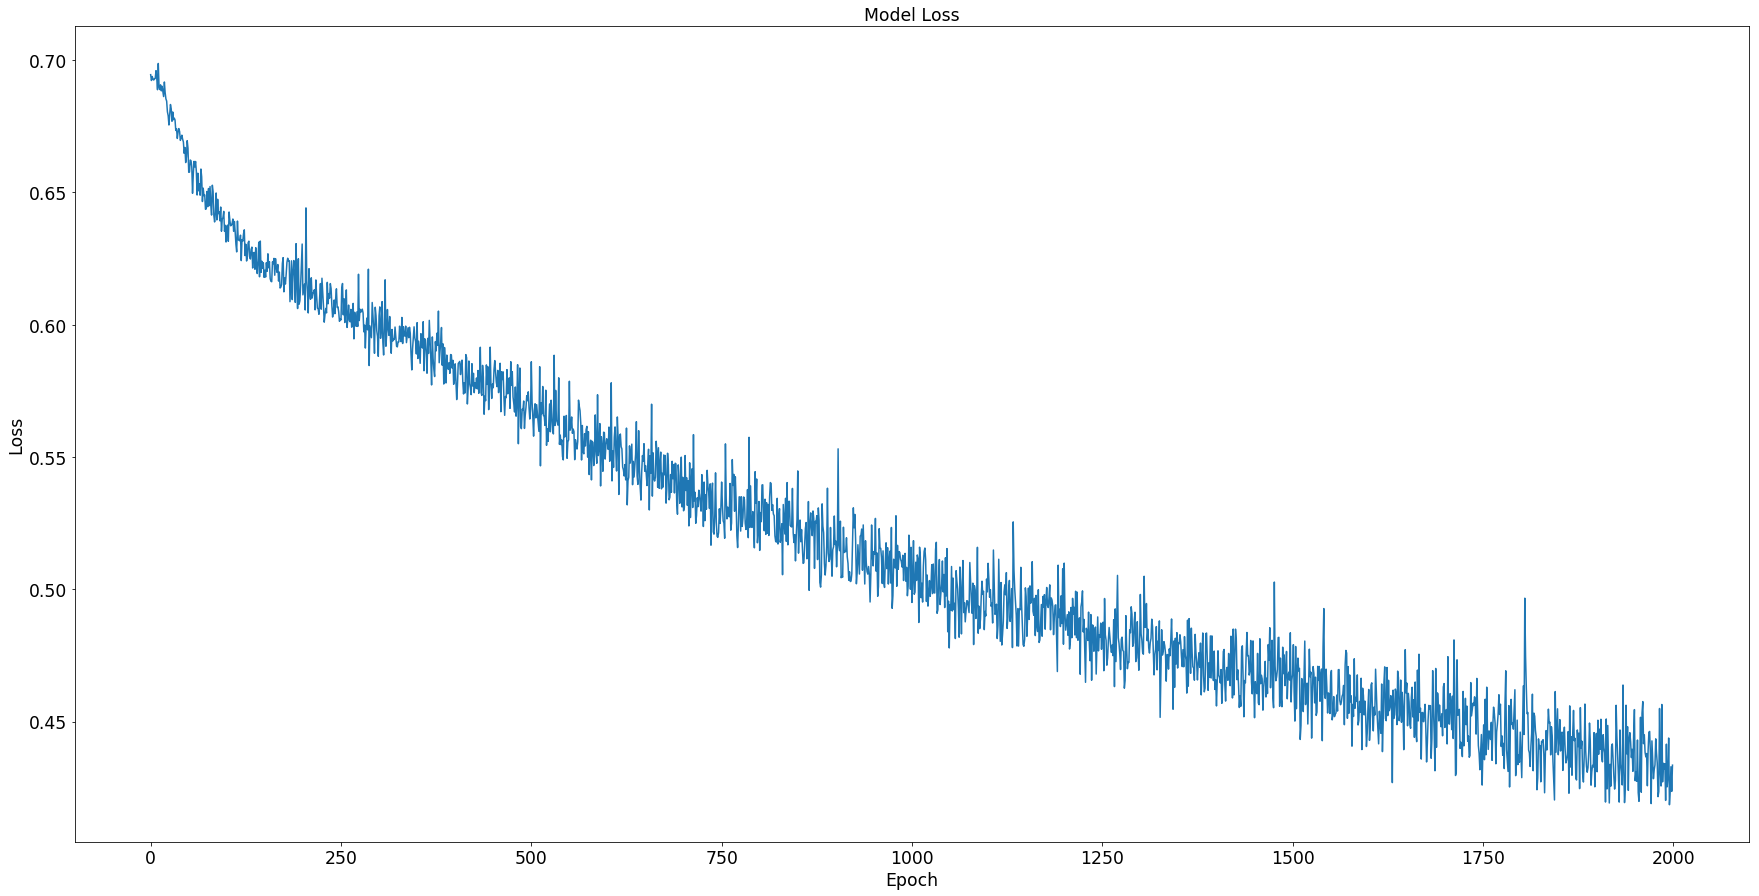

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
plot_loss(lstm_history)

In [9]:
# Evaluate model and predict data
scores = lstm_model.evaluate(x_test, y_test)
print("model: \n%s: %.2f%%" % (lstm_model.metrics_names[1], scores[1]*100))

y_predict = lstm_model.predict_classes(x_test)
cm = confusion_matrix(y_test, y_predict)
print(cm)

fpr_BDmodel, tpr_BDmodel, thresholds_BDmodel = roc_curve(y_test, y_predict)
auc_BDmodel = auc(fpr_BDmodel, tpr_BDmodel)
print(auc_BDmodel)

240/240 [==============================] - 0s 2ms/step
model: 
acc: 59.58%
[[90 53]
 [44 53]]
0.5878811909739744
